In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import init_notebooks
from analysis import Analisis

# Analyse par saisonnalité

In [74]:
ventes_seasonal = pd.read_csv("../data/processed/ventes_seasonal.csv", index_col='SaleDate', parse_dates=True)

In [75]:
ventes_seasonal.head()

,QuantityKg,UnitPrice,WholesalePrice,LossRate,QuantityCluster
SaleDate,,,,,
2020-07-01,229.168,5709.9,3424.11,10.803952,978
2020-07-02,137.249,3720.0,2194.87,10.915888,574
2020-07-03,108.995,2365.8,1443.48,11.304646,374
2020-07-04,102.801,2413.4,1425.49,10.556712,346
2020-07-05,106.455,2263.5,1329.93,11.350288,324


Afficher les premières lignes du DataFrame

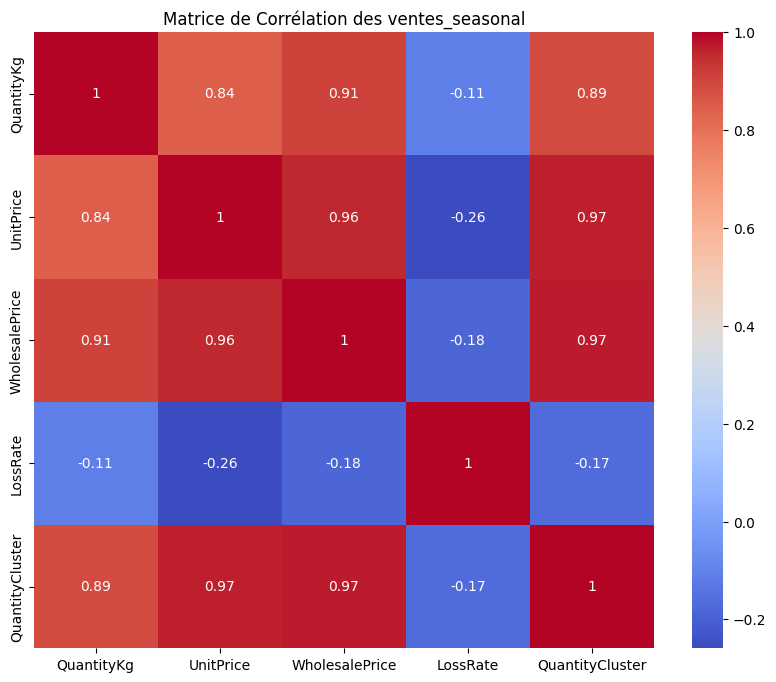

In [76]:
ventes_seasonal_corr = ventes_seasonal.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(ventes_seasonal_corr, annot=True, cmap='coolwarm')
plt.title('Matrice de Corrélation des ventes_seasonal')
plt.show()

Le résultat montre que les variables prix de gros, quantité (kg) et prix unitaire sont fortement corrélées entre elles,  avec un coefficient de corrélation atteignant 0.99 soit presque égale à 1. 

Cette relation, quasi parfaite, indique que ces variables évoluent de manière similaire au fil du temps. 

On peut mettre en place un modèle de régression permettant de prédire l’une de ces variables à partir des autres en évitant les colinéarités entre les variables et la redondance d’information dans le modèle. 

En revanche le Taux de perte présente une faible corrélation (-0,29 à -0,34) , cela veut dire que cette variable est relativement indépendante des autres et il apporte une information différente.

Tableau récapitulatif des coefficients et p-values :


         Variable       Coef       p-value                   Interprétation  Significatif
0           const  11.380645  7.514998e-13           const est significatif          True
1       UnitPrice  -0.011388  9.229880e-03       UnitPrice est significatif          True
2  WholesalePrice   0.082285  3.987557e-22  WholesalePrice est significatif          True


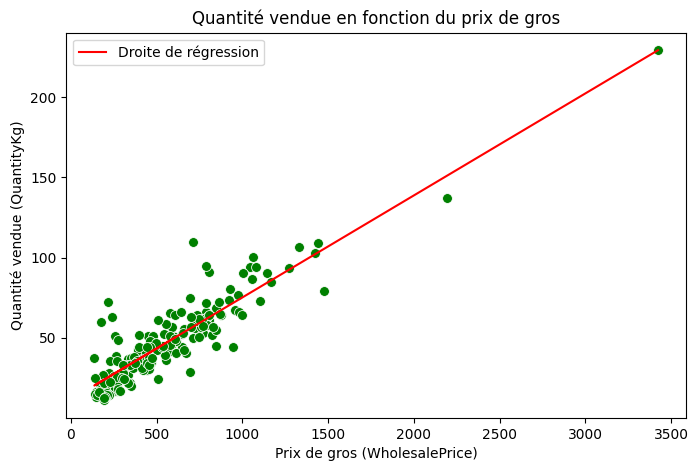

In [77]:
import pandas as pd
import statsmodels.api as sm

X = ventes_seasonal[['UnitPrice','WholesalePrice']]
y = ventes_seasonal['QuantityKg']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

summary_table = pd.DataFrame({
    'Variable': model.params.index,       
    'Coef': model.params.values,          
    'p-value': model.pvalues.values       
})


interpretation = []
for i, row in summary_table.iterrows():
    if row['p-value'] < 0.05:
        interpretation.append(f"{row['Variable']} est significatif")
    else:
        interpretation.append(f"{row['Variable']} n'est pas significatif")

summary_table['Interprétation'] = interpretation

summary_table['Significatif'] = summary_table['p-value'] < 0.05



print("Tableau récapitulatif des coefficients et p-values :")
print('\n')
print(summary_table.to_string())




plt.figure(figsize=(8,5))
sns.scatterplot(x='WholesalePrice', y='QuantityKg', data=ventes_seasonal, color='green', s=50)


X_const = sm.add_constant(ventes_seasonal['WholesalePrice'])
model_wp = sm.OLS(y, X_const).fit()
plt.plot(ventes_seasonal['WholesalePrice'], model_wp.predict(X_const), color='red', label='Droite de régression')

plt.title("Quantité vendue en fonction du prix de gros")
plt.xlabel("Prix de gros (WholesalePrice)")
plt.ylabel("Quantité vendue (QuantityKg)")
plt.legend()
plt.show()




L’intercepte est significatif. UnitPrice (prix unitaire) a un effet négatif sur QuantityKg (quantité vendue), ce qui signifie qu’une hausse du prix réduit la quantité vendue. WholesalePrice (prix de gros) a un effet positif, mais moins important.

Ainsi, le prix unitaire est la variable la plus influente pour les ventes, et son ajustement peut aider à vendre plus. Les données suivent bien la droite de régression : quand le prix de gros augmente, le prix unitaire augmente aussi.

In [78]:
# Prix moyen par kg
ventes_seasonal['AvgPriceKg'] = ventes_seasonal['WholesalePrice'] / ventes_seasonal['QuantityKg']

# Marge unitaire
ventes_seasonal['UnitMargin'] = ventes_seasonal['UnitPrice'] - ventes_seasonal['AvgPriceKg']

# Perte relative (%)
ventes_seasonal['RelativeLossRate'] = (ventes_seasonal['LossRate'] / ventes_seasonal['QuantityKg']) * 100

# Taux de marge (%)
ventes_seasonal['MarginRate'] = (ventes_seasonal['UnitPrice'] - ventes_seasonal['WholesalePrice']) / ventes_seasonal['WholesalePrice'] * 1000

ventes_seasonal.head()

,QuantityKg,UnitPrice,WholesalePrice,LossRate,QuantityCluster,AvgPriceKg,UnitMargin,RelativeLossRate,MarginRate
SaleDate,,,,,,,,,
2020-07-01,229.168,5709.9,3424.11,10.803952,978,14.941484,5694.958516,4.714424,667.557409
2020-07-02,137.249,3720.0,2194.87,10.915888,574,15.991883,3704.008117,7.953346,694.861199
2020-07-03,108.995,2365.8,1443.48,11.304646,374,13.243543,2352.556457,10.371711,638.955857
2020-07-04,102.801,2413.4,1425.49,10.556712,346,13.866499,2399.533501,10.269076,693.031870
2020-07-05,106.455,2263.5,1329.93,11.350288,324,12.492884,2251.007116,10.662053,701.969277


On créé ces nouvelles variables: 

Prix moyen par kg, permet de savoir combien réelement un kilogramme acheté en gros 

Marge unitaire, cela mesure la bénéfice par unité vendu (prix de vente - coût d'achat par kg) , si la valuer positive (gagne de l'argent ) si elle est négative (perte de l'argent) .

 Perte relative (%), regarde l’impact des pertes par rapport aux quantités, indique quelle proportion (%) da la marchandise est perdue 

Taux de marge (%), regarde la rentabilité globale par rapport au prix d’achat total , permet de comparer la rentabilité entre différent produit 

            QuantityKg  UnitPrice  WholesalePrice   LossRate  QuantityCluster  AvgPriceKg   UnitMargin  RelativeLossRate  MarginRate
SaleDate                                                                                                                            
2020-08-09      78.941     2049.8         1476.86   9.901459              320   18.708402  2031.091598         12.542860  387.944693
2020-10-16      45.069     1420.4          848.29  12.371731              186   18.822028  1401.577972         27.450644  674.427377
2020-10-22      44.426     1282.3          946.91  13.827798              196   21.314320  1260.985680         31.125463  354.194168
2020-11-10      24.288      745.8          506.80  12.370820              104   20.866271   724.933729         50.933875  471.586425
2020-11-20      51.198      253.4          255.09  13.728367               74    4.982421   248.417579         26.814265   -6.625113
2020-11-26      72.133      250.8          217.32  13.690000         

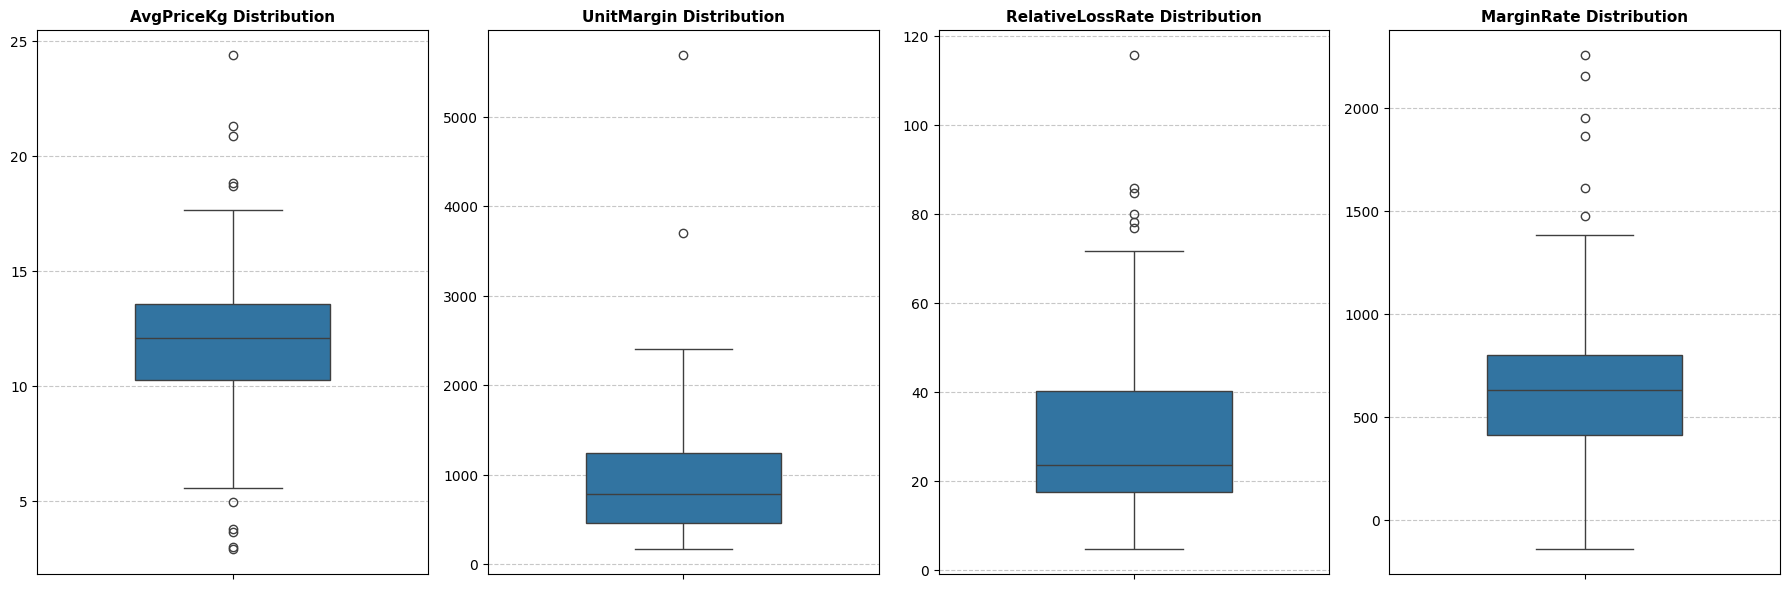

In [79]:
import init_notebooks 
from analysis import Analisis 
import matplotlib.pyplot as plt
import seaborn as sns

ventes_seasonal_analysis = Analisis(ventes_seasonal)

variables = ['AvgPriceKg', 'UnitMargin', 'RelativeLossRate', 'MarginRate']


for col in variables : 
    print(ventes_seasonal_analysis.iqr(col).to_string())
    print('\n')

fig, axes = plt.subplots(1, 4, figsize=(18,6))


for ax, var in zip(axes, variables):
    sns.boxplot(
        data=ventes_seasonal, y=var, ax=ax
       , width=0.5
    )
    ax.set_title(f"{var} Distribution", fontsize=11, fontweight="bold")
    ax.set_xlabel("")  
    ax.set_ylabel("")  
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Pour la variable AvgPriceKg, la distribution est centrée autour de la moyenne, mais certaines valeurs sont beaucoup plus élevées, ce qui peut indiquer des anomalies ou des ventes exceptionnelles.

Les variables UnitMargin, RelativeLossRate et MarginRate ont des valeurs généralement inférieures à la moyenne, avec quelques valeurs aberrantes présentes.

Dans l’ensemble, les données sont cohérentes, mais quelques valeurs extrêmes pourraient fausser certaines analyses. Il est possible de les corriger ou de les limiter pour rendre les résultats plus fiables.

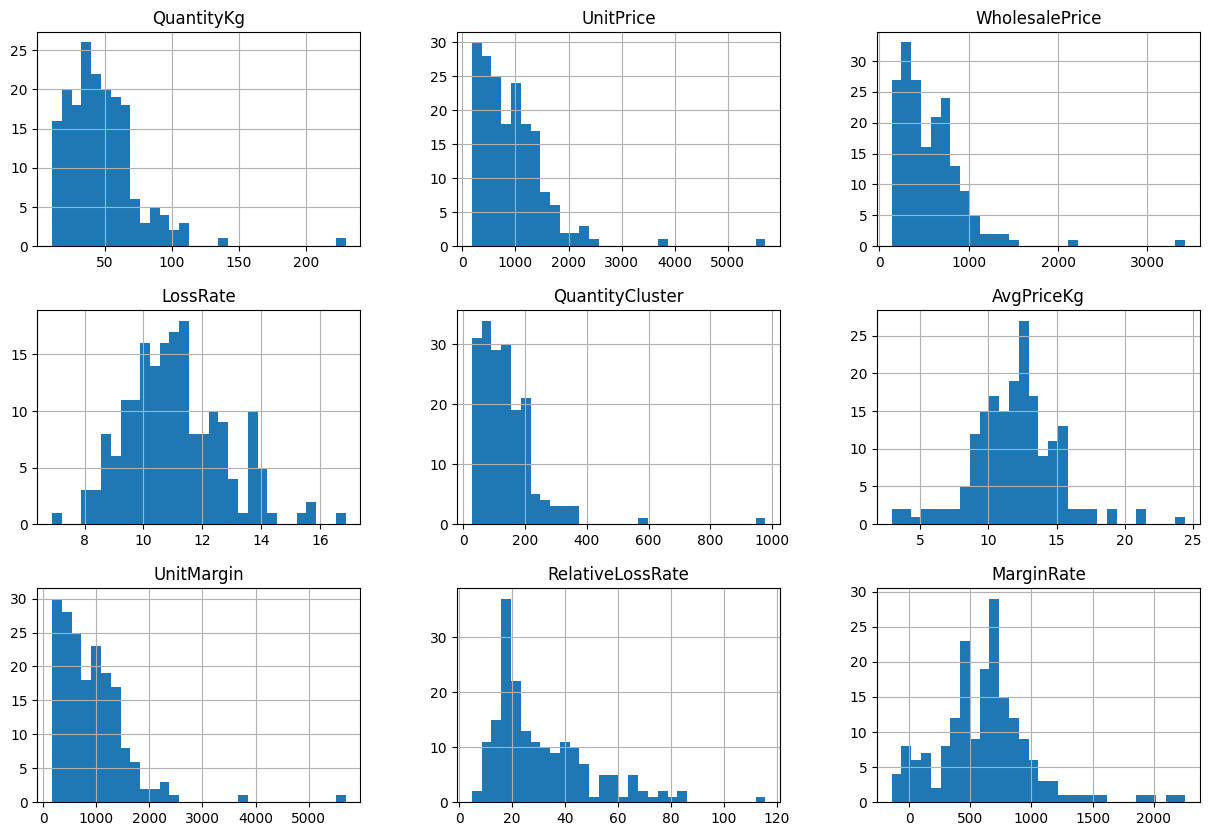

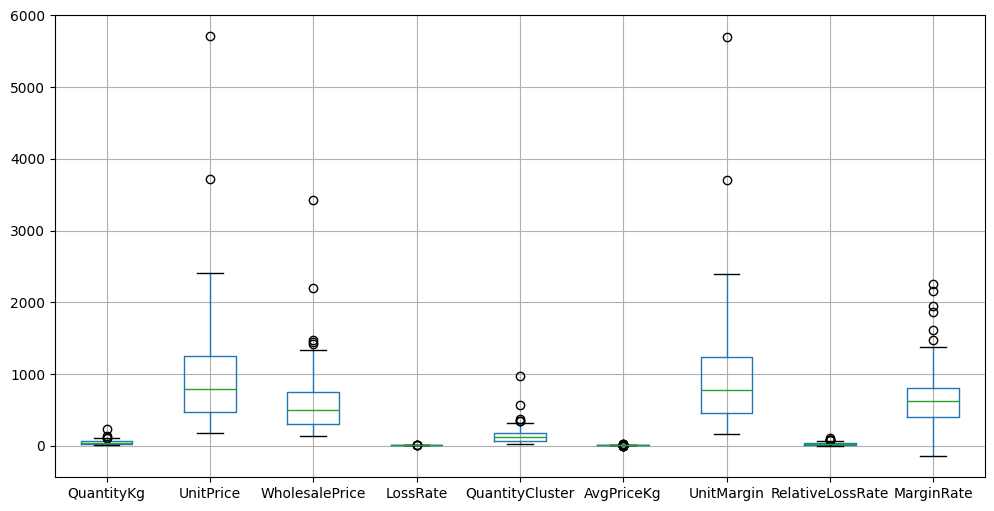

In [80]:
colonnes_numeriques = ventes_seasonal.select_dtypes(include=['int64', 'float64']).columns


ventes_seasonal[colonnes_numeriques].hist(bins=30, figsize=(15,10))
plt.show()
ventes_seasonal[colonnes_numeriques].boxplot(figsize=(12,6))
plt.show()

On constate que toutes les variables ne suivent pas une distribution normale et présentent des valeurs atypiques. 

Il peut être nécessaire de transformer les données ou de traiter les outliers avant certaines analyses.

array([[<Axes: title={'center': 'QuantityKg'}>,
        <Axes: title={'center': 'UnitPrice'}>,
        <Axes: title={'center': 'WholesalePrice'}>],
       [<Axes: title={'center': 'LossRate'}>,
        <Axes: title={'center': 'QuantityCluster'}>,
        <Axes: title={'center': 'AvgPriceKg'}>],
       [<Axes: title={'center': 'UnitMargin'}>,
        <Axes: title={'center': 'RelativeLossRate'}>,
        <Axes: title={'center': 'MarginRate'}>]], dtype=object)

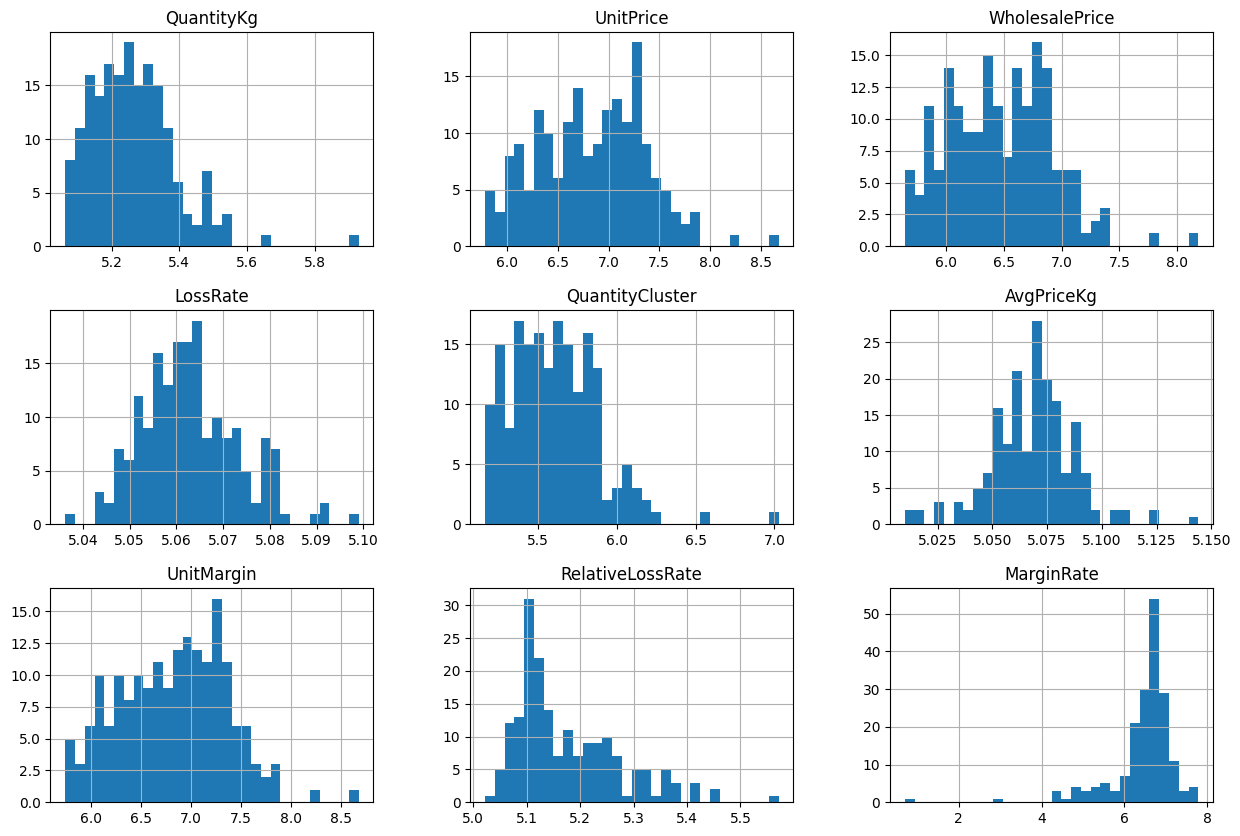

In [81]:
import numpy as np
import pandas as pd

# Supposons que ventes_seasonal et colonnes_numeriques sont déjà définis
colonnes_numeriques = ventes_seasonal.select_dtypes(include=['int64', 'float64']).columns

# Ajouter une constante pour gérer les valeurs négatives ou nulles (par exemple, 1 + valeur absolue du minimum)
min_values = ventes_seasonal[colonnes_numeriques].min()
shift = abs(min_values.min()) + 1  # Constante pour rendre toutes les valeurs positives
ventes_seasonal_shifted = ventes_seasonal[colonnes_numeriques] + shift

# Appliquer la transformation logarithmique
ventes_seasonal_log = np.log1p(ventes_seasonal_shifted)  # log(1 + x) pour gérer les zéros

# Convertir en DataFrame avec les mêmes noms de colonnes
ventes_seasonal_log = pd.DataFrame(ventes_seasonal_log, columns=colonnes_numeriques, index=ventes_seasonal.index)



ventes_seasonal_log.hist(bins=30, figsize=(15,10))

Après application de la transformation logarithmique, l’impact des valeurs extrêmes a été réduit et les distributions se rapprochent d’une forme plus normale.

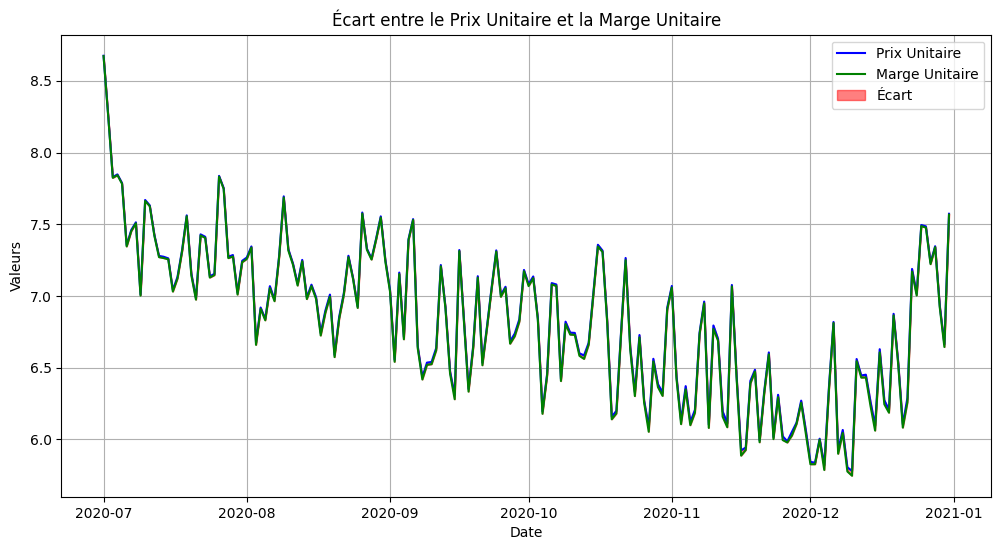

In [82]:
plt.figure(figsize=(12, 6))

plt.plot(ventes_seasonal_log.index, ventes_seasonal_log['UnitPrice'], label="Prix Unitaire", color="blue")
plt.plot(ventes_seasonal_log.index, ventes_seasonal_log['UnitMargin'], label="Marge Unitaire", color="green")


plt.fill_between(ventes_seasonal_log.index, ventes_seasonal_log['UnitMargin'], ventes_seasonal_log['UnitPrice'], 
                 color="red", alpha=0.5, label="Écart")

plt.title("Écart entre le Prix Unitaire et la Marge Unitaire")
plt.xlabel("Date")
plt.ylabel("Valeurs")
plt.legend()
plt.grid(True)
plt.show()

Le prix unitaire et la marge évoluent de manière similaire au fil du temps.

La marge est relativement faible par rapport au prix, donc l’écart entre le prix de vente et le coût moyen est petit.

Cela peut suggérer que les marges sont resserrées, ce qui peut être important pour la stratégie de prix ou l’optimisation des coûts.

In [83]:
ventes_seasonal_log = ventes_seasonal_log.drop('UnitMargin', axis=1) 

Apés l'analyse de l'écart entre le Prix Unitaire et la Marge Unitaire on supprime le UnitMargin pour éviter le redondance et simplifier l'analyse, sans perdre d’information importante. Si plus tard on as besoin de la marge, on peut la recalculer facilement.

k=2, Silhouette Score=0.4110
k=3, Silhouette Score=0.4270
k=4, Silhouette Score=0.3959
k=5, Silhouette Score=0.3252


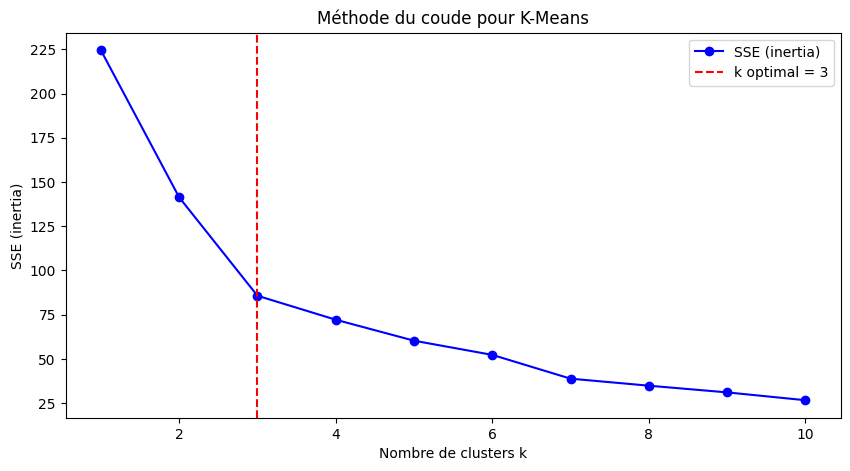

In [84]:
# Bloquer les warnings liés à KMeans / MKL
import os
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")

# Librairies
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
import pandas as pd
# Supposons que ventes_seasonal et colonnes_numeriques sont déjà définis
colonnes_numeriques = ventes_seasonal_log.select_dtypes(include=['int64', 'float64']).columns

# SSE (inertia) pour méthode du coude
sse = []
K = range(1, 11)  # tester k de 1 à 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(ventes_seasonal_log[colonnes_numeriques])
    sse.append(kmeans.inertia_)

# Calcul du Silhouette Score pour k = 2 à 5
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(ventes_seasonal_log[colonnes_numeriques])
    score = silhouette_score(ventes_seasonal_log[colonnes_numeriques], labels)
    print(f"k={k}, Silhouette Score={score:.4f}")

# Détecter le coude automatiquement
kneedle = KneeLocator(K, sse, curve='convex', direction='decreasing')
optimal_k = kneedle.knee

# Tracer la courbe du coude
plt.figure(figsize=(10, 5))
plt.plot(K, sse, 'bo-', label='SSE (inertia)')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'k optimal = {optimal_k}')
plt.xlabel('Nombre de clusters k')
plt.ylabel('SSE (inertia)')
plt.title('Méthode du coude pour K-Means')
plt.legend()
plt.show()


k=3 est le meilleur choix car les clusters sont plus compacts et mieux séparés.

In [85]:
from sklearn.cluster import KMeans

# k=2 par exemple
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(ventes_seasonal_log[colonnes_numeriques])

# Obtenir les labels (cluster de chaque observation)
ventes_seasonal_log["segmentation"] = kmeans.labels_

# Centres des clusters
print(kmeans.cluster_centers_)


[[5.16607434 6.420026   6.07195493 5.06443394 5.37558814 5.06362675
  5.25626599 6.61523694]
 [5.26208049 6.31184526 6.31687064 5.0750517  5.46553987 5.05461224
  5.19766753 4.67584173]
 [5.34044317 7.2669742  6.81530207 5.05924688 5.81563885 5.07497119
  5.10830707 6.69625593]]


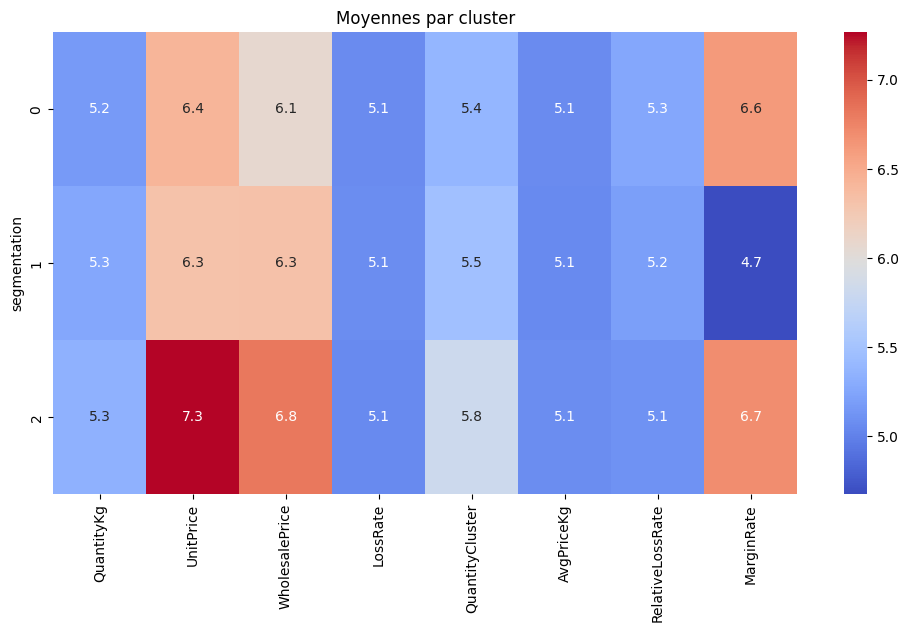

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

stats_clusters = ventes_seasonal_log.groupby('segmentation').agg(['mean', 'median', 'min', 'max'])

plt.figure(figsize=(12,6))
sns.heatmap(stats_clusters.xs('mean', axis=1, level=1), annot=True, cmap="coolwarm")
plt.title("Moyennes par cluster")
plt.show()


Cette heatmap suggère que les segments 0 et 2 sont associés à des ventes à plus forte valeur (prix et marges élevés), 

Tandis que le segment 1 pourrait représenter une catégorie intermédiaire avec une gestion plus efficace des pertes. 

Il serait utile de corréler ces moyennes avec d'autres facteurs (par exemple, volume de ventes ou saisonnalité) et de vérifier si les différences sont statistiquement significatives.

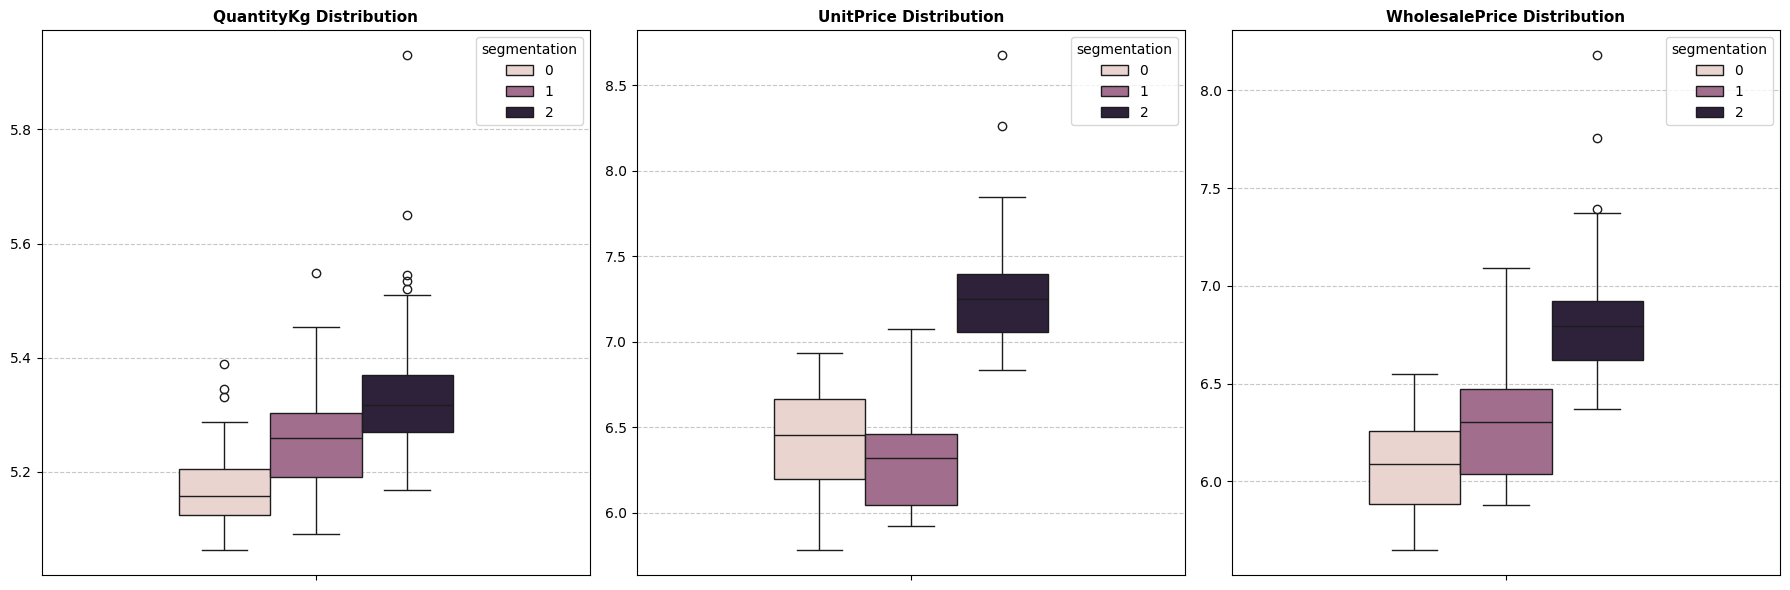

In [87]:
variables = ['QuantityKg', 'UnitPrice', 'WholesalePrice']

# Création des sous-graphes
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# ⚠️ Ici on utilise bien le DataFrame ventes_seasonal_scaled
for ax, var in zip(axes, variables):
    sns.boxplot(
        data=ventes_seasonal_log, y=var, ax=ax, hue='segmentation'
       , width=0.5
    )
    ax.set_title(f"{var} Distribution", fontsize=11, fontweight="bold")
    ax.set_xlabel("")  
    ax.set_ylabel("")  
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Ces boxplots suggèrent que la segmentation est fortement influencée par les prix (UnitPrice et WholesalePrice), avec le segment 2 représentant des produits ou marchés à plus haut prix et plus variés.

Tandis que le segment 0 est associé à des valeurs plus uniformes et stables.

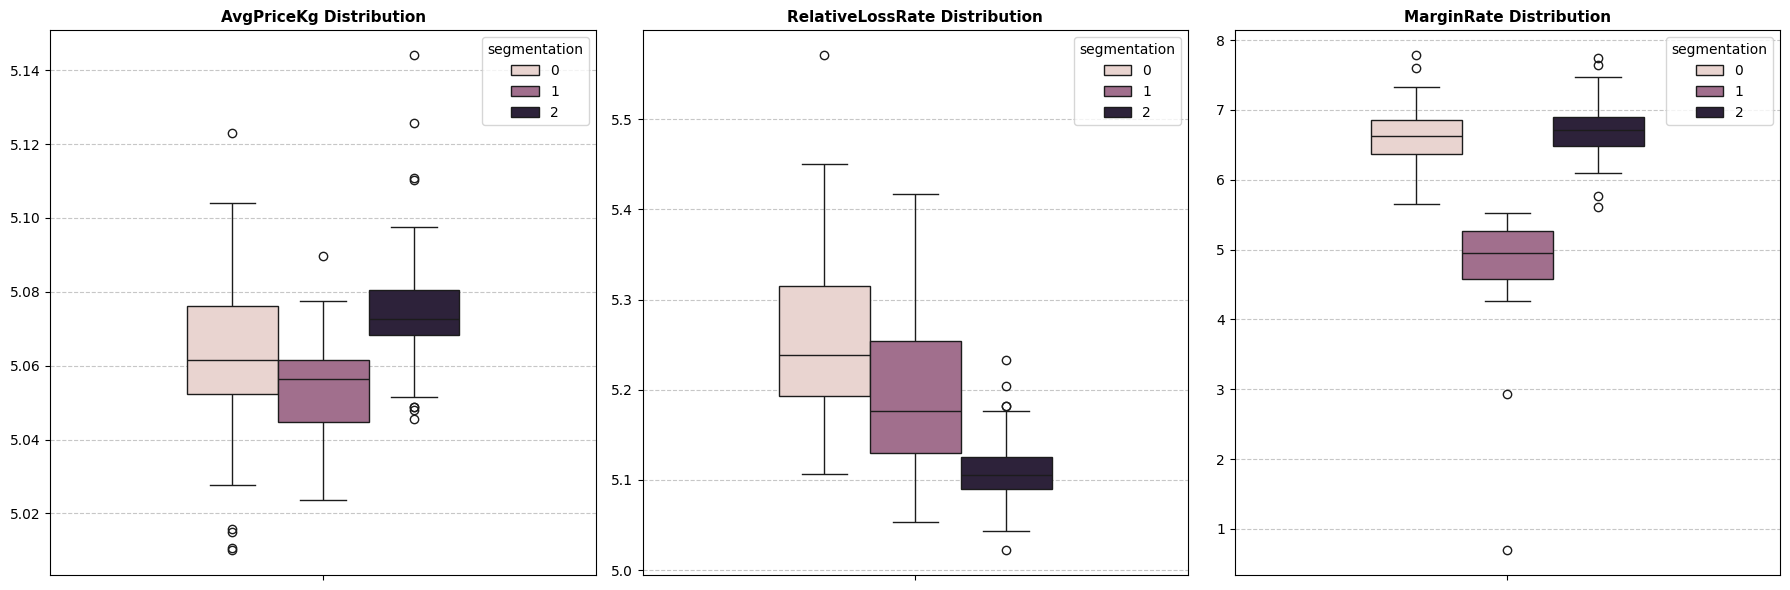

In [88]:
variables = ['AvgPriceKg', 'RelativeLossRate', 'MarginRate']

# Création des sous-graphes
fig, axes = plt.subplots(1, 3, figsize=(18,6))

# ⚠️ Ici on utilise bien le DataFrame ventes_seasonal_scaled
for ax, var in zip(axes, variables):
    sns.boxplot(
        data=ventes_seasonal_log, y=var, ax=ax, hue='segmentation'
       , width=0.5
    )
    ax.set_title(f"{var} Distribution", fontsize=11, fontweight="bold")
    ax.set_xlabel("")  
    ax.set_ylabel("")  
    ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


Ces boxplots indiquent que le segment 2 est associé à des marges plus élevées et des pertes relatives plus faibles, mais avec une plus grande variabilité.

Le segment 0 représente une catégorie stable avec des performances moyennes, tandis que le segment 1 pourrait correspondre à une catégorie intermédiaire avec des marges plus faibles. 

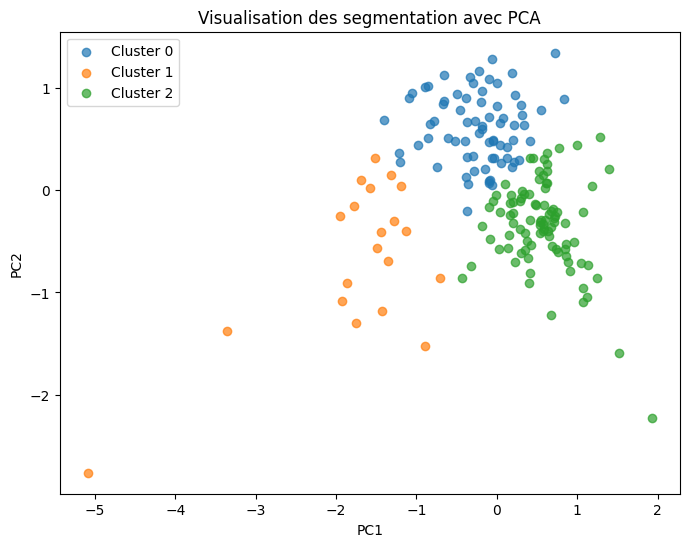

In [89]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd


# X_scaled : dataset normalisé
X_scaled = ventes_seasonal_log.drop(columns=['segmentation']).values
clusters = ventes_seasonal_log['segmentation'].values

pca = PCA(n_components=2)
ventes_seasonal_winsorized_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
for cluster in set(clusters):
    mask = clusters == cluster
    plt.scatter(ventes_seasonal_winsorized_pca[mask, 0], ventes_seasonal_winsorized_pca[mask, 1], label=f'Cluster {cluster}', alpha=0.7)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualisation des segmentation avec PCA')
plt.legend()
plt.show()

La visualisation par PCA montre une segmentation claire en trois clusters avec des caractéristiques distinctes.

Cluster 0 semble homogène et associé à des valeurs élevées de PC1, Cluster 1 est plus dispersé et lié à des valeurs négatives de PC1. 

Tandis que Cluster 2 occupe une position intermédiaire avec une variabilité notable.

Pour approfondir,Il serait utile de vérifier les pourcentages de variance expliquée par PC1 et PC2, ainsi que les corrélations avec les variables initiales.

         QuantityKg  UnitPrice  WholesalePrice  LossRate  QuantityCluster  AvgPriceKg  RelativeLossRate  MarginRate
Vente 1    5.166074   6.420026        6.071955  5.064434         5.375588    5.063627          5.256266    6.615237
Vente 2    5.262080   6.311845        6.316871  5.075052         5.465540    5.054612          5.197668    4.675842
Vente 3    5.340443   7.266974        6.815302  5.059247         5.815639    5.074971          5.108307    6.696256


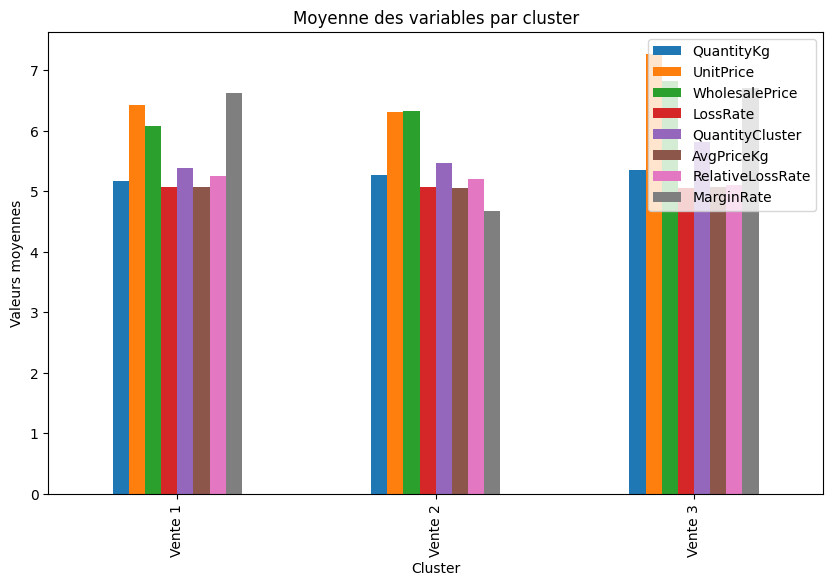

In [90]:
colonnes_numeriques = ventes_seasonal_log.select_dtypes(include=['float64', 'int64']).columns

ventes_seasonal_finaled = ventes_seasonal_log.groupby('segmentation')[colonnes_numeriques].mean()


ventes_seasonal_finaled.index = ['Vente 1', 'Vente 2', 'Vente 3']

print(ventes_seasonal_finaled.to_string())


ventes_seasonal_finaled.plot(kind='bar', figsize=(10,6))

plt.title("Moyenne des variables par cluster")
plt.ylabel("Valeurs moyennes")
plt.xlabel("Cluster")
plt.show()


Vente 1 pourrait correspondre à des produits à forte valeur ajoutée ou à des ventes optimisées avec de bonnes marges.

Vente 2 semble être une variante de Vente 1, peut-être avec des coûts légèrement plus élevés.

Vente 3 pourrait représenter des prix plus bas et une marge réduite, cohérent avec tes observations initiales de pertes élevées et prix faibles, bien que les pertes ici soient modérées.

In [91]:
ventes_seasonal_log.shape

(184, 9)

In [92]:
ventes_seasonal_log.head()

,QuantityKg,UnitPrice,WholesalePrice,LossRate,QuantityCluster,AvgPriceKg,RelativeLossRate,MarginRate,segmentation
SaleDate,,,,,,,,,
2020-07-01,5.930010,8.675374,8.180629,5.061292,7.025530,5.087176,5.021936,6.702633,2
2020-07-02,5.649817,8.260232,7.758701,5.062002,6.580626,5.093641,5.043062,6.735604,2
2020-07-03,5.545120,7.829149,7.371785,5.064460,6.255732,5.076635,5.058549,6.666888,2
2020-07-04,5.520626,7.847915,7.360410,5.059724,6.200490,5.080515,5.057897,6.733428,2
2020-07-05,5.535148,7.787585,7.297714,5.064749,6.154838,5.071939,5.060393,6.744012,2


In [93]:
ventes_seasonal_log.to_csv('../data/reports/ventes_seasonal.csv', index=True)

# Analyse quotidienne

In [94]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
ventes_not_seasonal = pd.read_csv("../data/processed/ventes_not_seasonal.csv", index_col='DateTime', )

In [96]:
ventes_not_seasonal.head()

,ItemCode,ItemName,CategoryCode,CategoryName,QuantityKg,UnitPrice,WholesalePrice,LossRate,QuantityCluster
DateTime,,,,,,,,,
2020-07-01 16:27:36.983,0,Amaranth,0,Flower/Leaf Vegetables,0.920,6.0,3.88,18.52,0
2020-07-03 09:19:18.438,0,Amaranth,0,Flower/Leaf Vegetables,0.886,6.0,3.88,18.52,0
2020-07-09 09:54:40.682,0,Amaranth,0,Flower/Leaf Vegetables,0.944,5.0,3.88,18.52,0
2020-07-12 10:38:15.217,0,Amaranth,0,Flower/Leaf Vegetables,1.044,5.0,3.88,18.52,0
2020-07-23 11:25:53.623,0,Amaranth,0,Flower/Leaf Vegetables,0.950,7.6,3.88,18.52,0


In [97]:
ventes_not_seasonal.shape

(16260, 9)

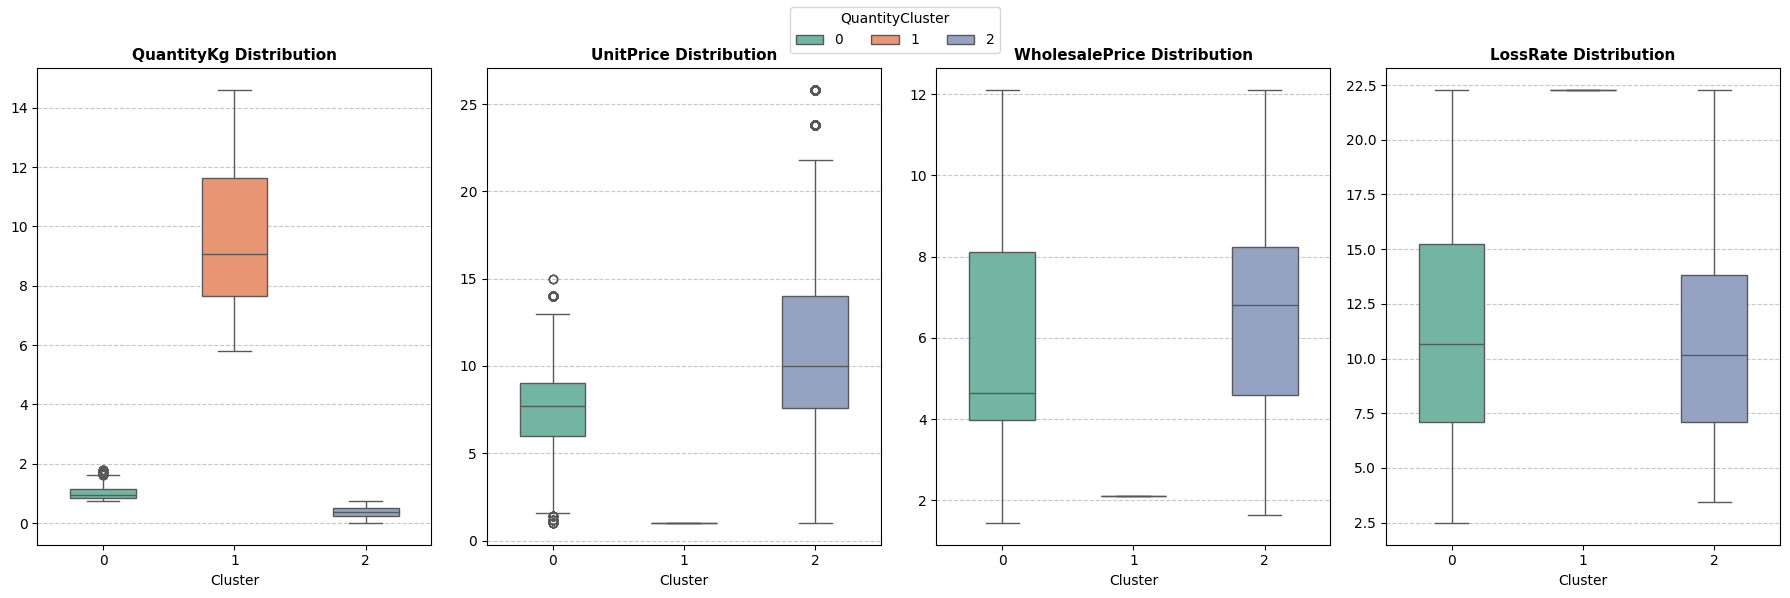

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

variables = ['QuantityKg', 'UnitPrice', 'WholesalePrice', 'LossRate']


fig, axes = plt.subplots(1, 4, figsize=(18,6))

for i, (ax, var) in enumerate(zip(axes, variables)):
    sns.boxplot(
        data=ventes_not_seasonal,
        x='QuantityCluster',
        y=var,
        ax=ax,
        width=0.5,
        hue='QuantityCluster',   
        palette='Set2',
        legend=(i==0)            
    )
    ax.set_title(f"{var} Distribution", fontsize=11, fontweight="bold")
    ax.set_xlabel("Cluster")  
    ax.set_ylabel("")  
    ax.grid(axis="y", linestyle="--", alpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="QuantityCluster", loc="upper center", ncol=len(labels))


axes[0].get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Il apparaît que, cluster 1 présente de grand quantité de vente avec un prix et perte de vente filable, c'est le ventre plus rentable.

Tandis que, cluster 0, 2 ont prix quantité vendue et présence grande perte, c'est ventre qu'il faut surveiller  

In [99]:
# Marge
ventes_not_seasonal['Margin'] = (ventes_not_seasonal['UnitPrice'] - ventes_not_seasonal['WholesalePrice'])


# Marge net
ventes_not_seasonal["NetMargin"] = ventes_not_seasonal["Margin"] * (1 - ventes_not_seasonal["LossRate"] / 100)


# Taux de marge (%)
ventes_not_seasonal['MarginRate'] = (ventes_not_seasonal['UnitPrice'] - ventes_not_seasonal['WholesalePrice']) / ventes_not_seasonal['WholesalePrice'] * 1000


ventes_not_seasonal['Margin_Loss_Ratio_pct'] = (ventes_not_seasonal['MarginRate'] / ventes_not_seasonal['LossRate']) * 100

Ces variable ont pour objectifs de connaitre la profitabilité avant pertes.

Plus cette valeur est élevée, plus le produit est rentable en théorie.

On peut analyser par produit, catégorie, ou cluster pour identifier les ventes les plus rentables.

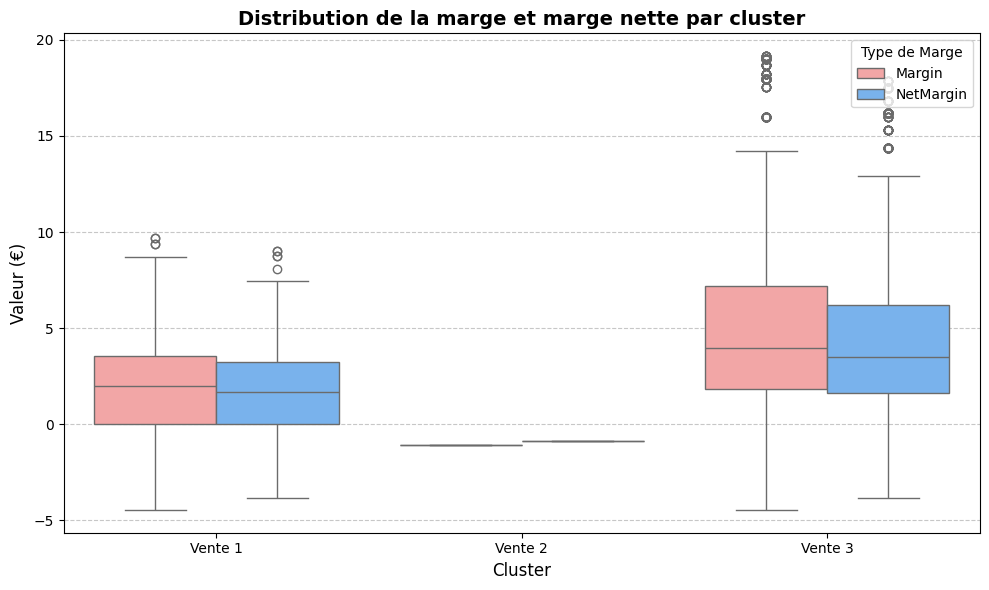

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Remplacer les numéros de cluster par des noms
cluster_labels = {0: "Vente 1", 1: "Vente 2", 2: "Vente 3"}
ventes_not_seasonal['ClusterLabel'] = ventes_not_seasonal['QuantityCluster'].map(cluster_labels)

# Préparer les données pour un boxplot combiné
ventes_melted = ventes_not_seasonal.melt(
    id_vars="ClusterLabel",
    value_vars=["Margin", "NetMargin"],
    var_name="Type de Marge",
    value_name="Valeur"
)

# Création de la figure
plt.figure(figsize=(10, 6))

# Boxplot combiné
sns.boxplot(
    data=ventes_melted,
    x="ClusterLabel",
    y="Valeur",
    hue="Type de Marge",
    palette={"Margin": "#FF9999", "NetMargin": "#66B2FF"}
)

# Personnalisation
plt.title("Distribution de la marge et marge nette par cluster", fontsize=14, fontweight="bold")
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Valeur (€)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Type de Marge", loc="upper right")
plt.tight_layout()
plt.show()


Vente 1 : Bénéfices positifs mais modestes , rentabilité faible.

Vente 2 : Pertes ou marges nulles , ventes non rentables.

Vente 3 : Bénéfices élevés , ventes très rentables, peuvent compenser les pertes.

Top produits par marge nette (Cluster 2) :
                            Margin  NetMargin
ItemName                                     
Red Hang Pepper          10.817229   9.736588
7 Colour Pepper (1)      10.435957   8.768291
The Red Bell Pepper (1)   8.651775   7.879171
Jigu Mushroom (1)         7.828889   7.125072
Red Pepper (1)            7.736711   6.826873
Xixia Mushroom (1)        7.849869   6.765017
Paopaojiao (Jingpin)      7.030965   6.533173
Green Line Pepper         6.792016   6.262239
Green Hot Peppers         6.255652   5.835272
Luosi Pepper              6.137966   5.513121


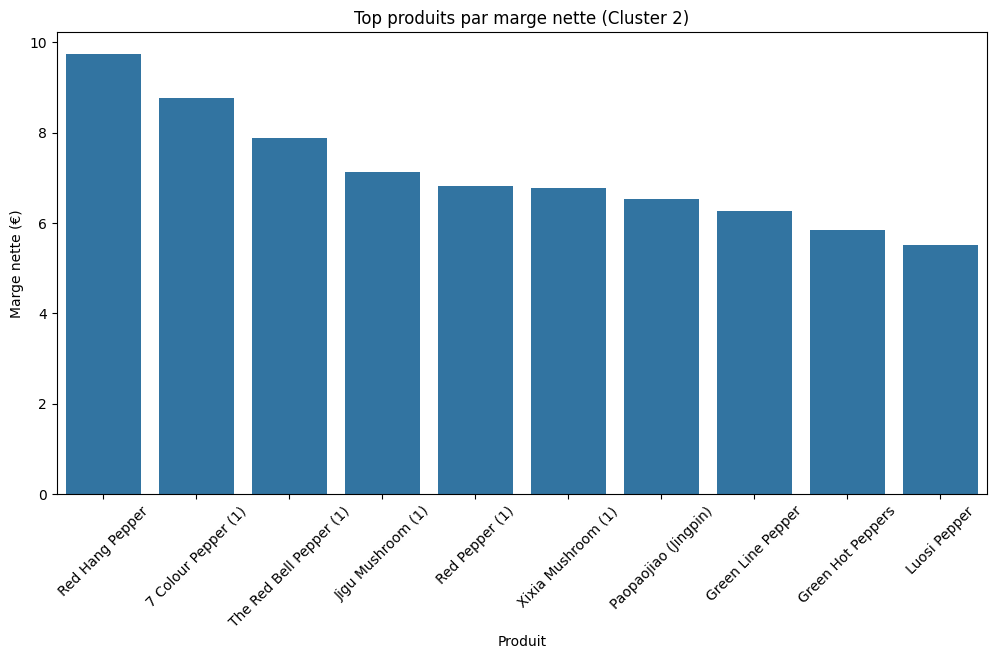

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filtrer le cluster rentable
cluster2 = ventes_not_seasonal[ventes_not_seasonal['QuantityCluster'] == 2]

# Marges moyennes par produit
marge_par_produit = cluster2.groupby('ItemName')[['Margin', 'NetMargin']].mean().sort_values('NetMargin', ascending=False)
print("Top produits par marge nette (Cluster 2) :")
print(marge_par_produit.head(10))

# Visualiser les marges par produit
plt.figure(figsize=(12,6))
sns.barplot(data=marge_par_produit.head(10).reset_index(), x='ItemName', y='NetMargin')
plt.xticks(rotation=45)
plt.title("Top produits par marge nette (Cluster 2)")
plt.ylabel("Marge nette (€)")
plt.xlabel("Produit")
plt.show()


L’analyse des marges dans le cluster le plus rentable (Cluster 2) met en évidence un ensemble de produits à forte contribution, notamment

Red Hang Pepper, 7 Colour Pepper (1) et The Red Bell Pepper (1).

Ces produits présentent des marges nettes élevées (> 5), ce qui en fait des produits clés à privilégier dans la stratégie commerciale (promotion, stock, prix). L’identification de ces produits permet de concentrer les efforts sur les segments les plus profitables pour améliorer la rentabilité globale.

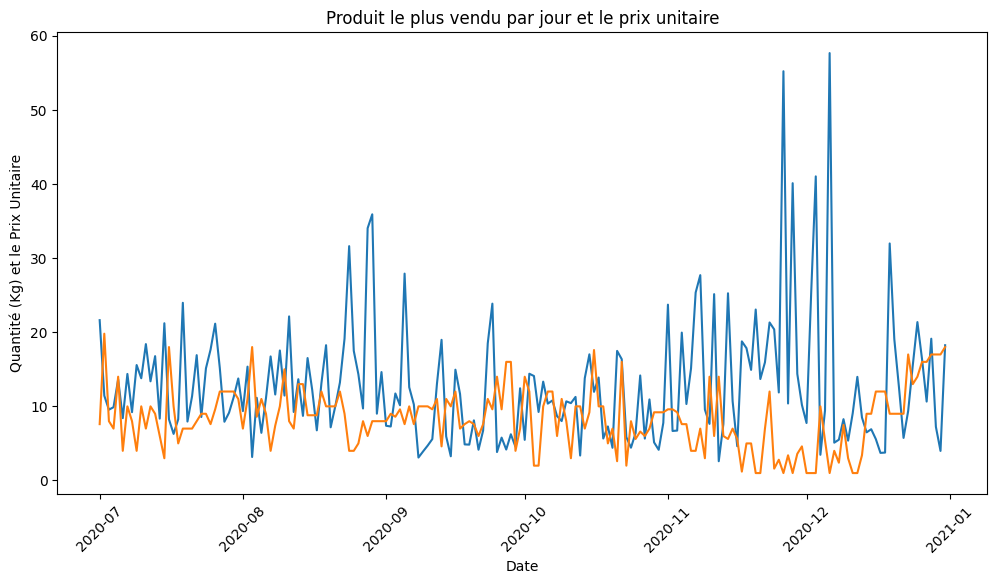

In [102]:
import pandas as pd

ventes_not_seasonal = ventes_not_seasonal.reset_index()

# Assurer que DateTime est bien en datetime
ventes_not_seasonal['DateTime'] = pd.to_datetime(ventes_not_seasonal['DateTime'])

# Extraire uniquement la date (pas l'heure)
ventes_not_seasonal['Date'] = ventes_not_seasonal['DateTime'].dt.date

# Agréger par jour et produit
daily_product_sum = ventes_not_seasonal.groupby(['Date', 'ItemName']).agg({
    'QuantityKg': 'sum',
    'UnitPrice': 'median',       # présence des outliser 
    'WholesalePrice': 'mean',    # pas d'outlier
}).reset_index()

# Trouver la quantité max par jour
max_quantity_per_day = daily_product_sum.groupby('Date')['QuantityKg'].transform('max')

# Filtrer les produits top
top_products_per_day = daily_product_sum[daily_product_sum['QuantityKg'] == max_quantity_per_day]

# Voir résultat


plt.figure(figsize=(12,6))
plt.plot(top_products_per_day['Date'], top_products_per_day['QuantityKg'])
plt.plot(top_products_per_day['Date'], top_products_per_day['UnitPrice'] )

plt.title("Produit le plus vendu par jour et le prix unitaire")
plt.xlabel("Date")
plt.ylabel("Quantité (Kg) et le Prix Unitaire")
plt.xticks(rotation=45)
plt.show()

L'analyse montre que,le prix sont stable er faible , les produits ont un profil saisonnier marqué, avec des quantité ventes plus élevées en certaines périodes de l’année sur tous le décembre.

Il faudra anticiper les pics de décembre et les variations fin août.

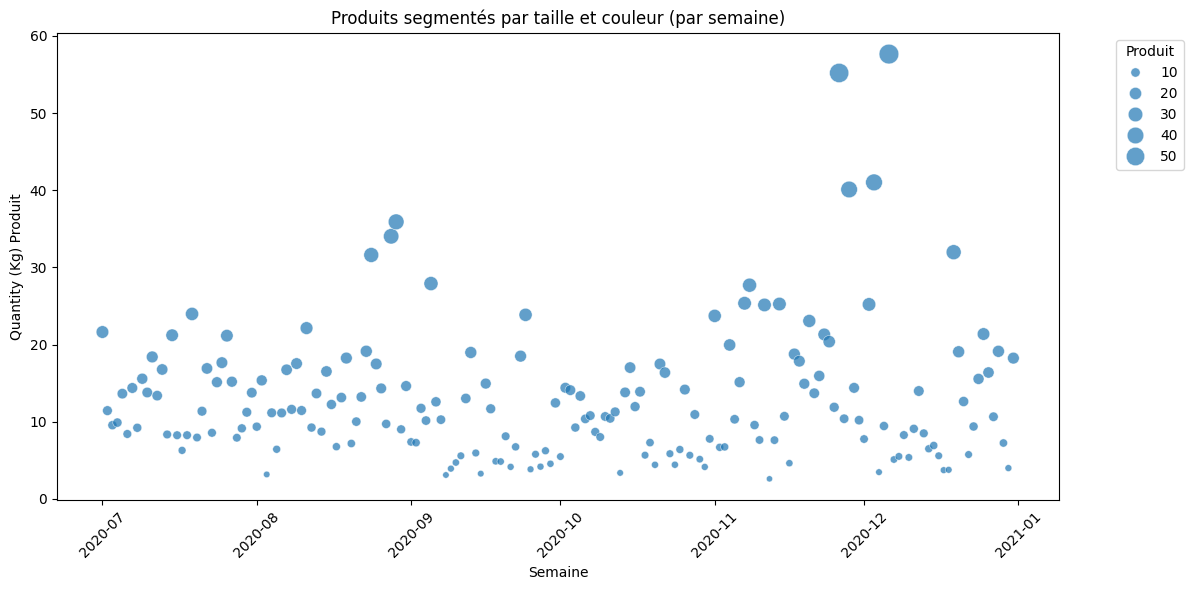

In [103]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=top_products_per_day,
    x='Date',
    y='QuantityKg',
    size='QuantityKg',
    sizes=(20,200),
    alpha=0.7
)
plt.xticks(rotation=45)
plt.title("Produits segmentés par taille et couleur (par semaine)")
plt.xlabel("Semaine")
plt.ylabel("Quantity (Kg) Produit")
plt.legend(title='Produit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


On observe que ,la majorité des produits se vendent en petites quantités (10 à 20 Kg) de manière régulière au fil du temps.

Tous le proquit vendu sont à la majorité de taille 10 et 20 des petite qunatité au fill temps saul pourpour fin aout et de mois de decenbre

In [104]:
ventes_not_seasonal.head()

,DateTime,ItemCode,ItemName,CategoryCode,CategoryName,QuantityKg,UnitPrice,WholesalePrice,LossRate,QuantityCluster,Margin,NetMargin,MarginRate,Margin_Loss_Ratio_pct,ClusterLabel,Date
0,2020-07-01 16:27:36.983,0,Amaranth,0,Flower/Leaf Vegetables,0.920,6.0,3.88,18.52,0,2.12,1.727376,546.391753,2950.279442,Vente 1,2020-07-01
1,2020-07-03 09:19:18.438,0,Amaranth,0,Flower/Leaf Vegetables,0.886,6.0,3.88,18.52,0,2.12,1.727376,546.391753,2950.279442,Vente 1,2020-07-03
2,2020-07-09 09:54:40.682,0,Amaranth,0,Flower/Leaf Vegetables,0.944,5.0,3.88,18.52,0,1.12,0.912576,288.659794,1558.638196,Vente 1,2020-07-09
3,2020-07-12 10:38:15.217,0,Amaranth,0,Flower/Leaf Vegetables,1.044,5.0,3.88,18.52,0,1.12,0.912576,288.659794,1558.638196,Vente 1,2020-07-12
4,2020-07-23 11:25:53.623,0,Amaranth,0,Flower/Leaf Vegetables,0.950,7.6,3.88,18.52,0,3.72,3.031056,958.762887,5176.905435,Vente 1,2020-07-23


In [105]:
ventes_not_seasonal.to_csv('../data/reports/ventes_not_seasonal.csv', index=False)